# 4.0 — EGARCH & GJR-GARCH vs EWM (SPX)

**Explication :**
1) Charge le CSV garch_forecasts.csv en parsant la colonne date et affiche les premières lignes.  
2) Lit le fichier metrics.json et le convertit en dictionnaire Python via json.loads.  
3) Affiche les métriques calculées (RMSE, MAE, benchmarks, etc.).  

**Pourquoi nous avons fait cela:**
1) Lire le CSV permet d’inspecter les prévisions et leur alignement avec les dates.  
2) Charger metrics.json donne un accès direct aux scores de performance pour reporting ou analyse.  
3) Afficher un aperçu (head + metrics) facilite le debug et la validation des résultats sans ouvrir les fichiers manuellement.  


In [ ]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from tqdm import tqdm   

PROC_DIR = Path("data/processed")
OUT_DIR  = Path("data/models/garch_plus")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TRADING_DAYS = 252
ROLL_WIN = 1260
SERIES_FILE = PROC_DIR / "spx_index_features.parquet"


## 4.1 Fonctions annualize et roll_forecast (EGARCH / GJR)

**Explication :**
1) La fonction annualize multiplie un écart-type quotidien par √TRADING_DAYS pour obtenir une volatilité annualisée.  
2) La fonction roll_forecast lance un backtest rolling 1-step ahead pour une spécification donnée (EGARCH ou GJR).  
3) Pour chaque fenêtre de taille ROLL_WIN, elle entraîne le modèle sur les rendements passés (train).  
4) Selon le paramètre spec, elle choisit soit un EGARCH(1,1), soit un GJR-GARCH(1,1,1).  
5) Chaque modèle est estimé (fit) avec distribution Student-t et moyenne constante.  
6) La variance forecastée à J+1 est extraite, puis convertie en écart-type quotidien (%).  
7) Toutes les prévisions sont collectées dans preds, mises à l’échelle (1.0 = 100%), annualisées et renvoyées en %.  
8) tqdm affiche une barre de progression pour suivre l’avancement du rolling.  

**Pourquoi nous avons fait cela:**
1) Annualiser les prévisions permet une mesure comparable avec les standards du marché.  
2) Le backtest rolling évite le look-ahead bias et simule des conditions réelles de prévision.  
3) Tester EGARCH et GJR permet de capturer respectivement l’asymétrie conditionnelle (leviers) et l’effet des chocs négatifs.  
4) Factoriser la logique dans une fonction rend le code réutilisable et extensible à d’autres spécifications GARCH.  


In [ ]:
def annualize(x): 
    return x * np.sqrt(TRADING_DAYS)

def roll_forecast(ret_pct: pd.Series, spec: str):
    preds = []
    for i in tqdm(range(ROLL_WIN, len(ret_pct)-1), desc=f"{spec} rolling", ncols=100):
        train = ret_pct.iloc[i-ROLL_WIN:i].dropna()
        if spec == "EGARCH":
            am = arch_model(train, vol="EGARCH", p=1, q=1, dist="t", mean="constant")
        elif spec == "GJR":
            am = arch_model(train, vol="GARCH", p=1, o=1, q=1, dist="t", mean="constant")
        else:
            raise ValueError("spec must be EGARCH or GJR")
        res = am.fit(disp="off")
        f = res.forecast(horizon=1, reindex=False)
        sd_d_pct = float(np.sqrt(f.variance.values[-1,0]))
        preds.append(sd_d_pct)
    preds = np.array(preds) / 100.0  
    return annualize(preds) * 100.0   


### 4.2 main – EGARCH/GJR rolling forecasts + scoring + export

**Explication :**
1) Charge le parquet SERIES_FILE, trie par date et réinitialise l’index.  
2) Prépare les cibles et benchmarks alignés après la fenêtre d’apprentissage :  
   - dates = df["date"][ROLL_WIN+1:],  
   - y = vol réalisée 21j en %,  
   - ewm = vol EWM(λ=0.94) en %,  
   - ret_pct = rendements quotidiens en %.  
3) Calcule les prévisions rolling 1-step ahead avec barre de progression :  
   - egarch = roll_forecast(ret_pct, "EGARCH"),  
   - gjr = roll_forecast(ret_pct, "GJR").  
4) Concatène dans un DataFrame (date, vol_real, vol_ewm, vol_egarch, vol_gjr) et sauvegarde garch_plus_forecasts.csv.  
5) Définit une fonction scores(pred, name) qui retourne RMSE et MAE vs y.  
6) Calcule les métriques pour EWM, EGARCH(1,1) et GJR(1,1) puis écrit metrics.json.  
7) Trace les séries temporelles (réalisée, EWM, EGARCH, GJR) et enregistre garch_plus_vs_real.png.  
8) Imprime un récapitulatif des métriques (RMSE/MAE) en console.  

**Pourquoi nous avons fait cela:**
1) Le décalage ROLL_WIN+1 aligne correctement train/test et évite tout look-ahead bias.  
2) Comparer EGARCH et GJR à un benchmark EWM fournit une évaluation juste et interprétable.  
3) L’export CSV/JSON/PNG permet traçabilité, partage et réutilisation (reporting/analyses ultérieures).  
4) La fonction scores factorise le calcul des erreurs et standardise les comparaisons entre modèles.  
5) La visualisation temporelle met en évidence les régimes de vol et les écarts de modèles d’un coup d’œil.  


In [ ]:
def main():
    df = pd.read_parquet(SERIES_FILE).sort_values("date").reset_index(drop=True)
    dates = df["date"].iloc[ROLL_WIN+1:].reset_index(drop=True)
    y = (df["vol21"].iloc[ROLL_WIN+1:] * 100.0).reset_index(drop=True).values
    ewm = (df["vol_ewm_094"].iloc[ROLL_WIN+1:] * 100.0).reset_index(drop=True).values
    ret_pct = (df["ret_d_clamped"] * 100.0)

    egarch = roll_forecast(ret_pct, "EGARCH")
    gjr    = roll_forecast(ret_pct, "GJR")

    out = pd.DataFrame({
        "date": dates,
        "vol_real": y,
        "vol_ewm": ewm,
        "vol_egarch": egarch,
        "vol_gjr": gjr
    })
    out.to_csv(OUT_DIR/"garch_plus_forecasts.csv", index=False)

    def scores(pred, name):
        rmse = float(np.sqrt(((pred - y)**2).mean()))
        mae  = float(np.abs(pred - y).mean())
        return {"model": name, "rmse": rmse, "mae": mae}

    metrics = [
        scores(ewm, "EWM"),
        scores(egarch, "EGARCH(1,1)"),
        scores(gjr, "GJR(1,1)")
    ]
    Path(OUT_DIR/"metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")

    plt.figure(figsize=(12,6))
    plt.plot(out["date"], out["vol_real"], label="Realized Vol (21d)", alpha=0.7)
    plt.plot(out["date"], out["vol_ewm"],  label="EWM λ=0.94", alpha=0.8)
    plt.plot(out["date"], out["vol_egarch"], label="EGARCH(1,1) Forecast", alpha=0.8)
    plt.plot(out["date"], out["vol_gjr"],    label="GJR(1,1) Forecast", alpha=0.8)
    plt.legend()
    plt.title("Vol Forecasts: EGARCH/GJR vs EWM vs Realized")
    plt.tight_layout()
    plt.savefig(OUT_DIR/"garch_plus_vs_real.png", dpi=150)
    plt.close()

    print("✅ garch_plus terminé. Metrics:")
    for m in metrics:
        print(" ", m["model"], "→ RMSE", round(m["rmse"],3), "| MAE", round(m["mae"],3))


In [4]:
if __name__ == "__main__":
    main()


GJR rolling: 100%|██████████████████████████████████████████████| 6891/6891 [09:40<00:00, 11.87it/s]


✅ garch_plus terminé. Metrics:
  EWM → RMSE 2.157 | MAE 1.493
  EGARCH(1,1) → RMSE 3.129 | MAE 2.309
  GJR(1,1) → RMSE 4.279 | MAE 2.88


### 4.3 Lecture des sorties EGARCH/GJR (CSV + JSON)

**Explication :**
1) Charge le CSV garch_plus_forecasts.csv en parsant la colonne date et affiche les premières lignes.  
2) Lit le fichier metrics.json et le convertit en dictionnaire Python via json.loads.  
3) Affiche les métriques calculées (RMSE, MAE pour EWM, EGARCH et GJR).  

**Pourquoi nous avons fait cela:**
1) Inspecter le CSV permet de valider que les prévisions (vol_real, vol_ewm, vol_egarch, vol_gjr) sont bien alignées sur les dates.  
2) Charger metrics.json permet d’accéder directement aux scores de performance pour chaque modèle testé.  
3) L’aperçu (head + metrics) facilite le contrôle, le debug et la validation avant toute analyse plus poussée.  


In [5]:
from pathlib import Path
import pandas as pd, json

out_dir = Path("data/models/garch_plus")
print(sorted(p.name for p in out_dir.glob("*")))

df = pd.read_csv(out_dir/"garch_plus_forecasts.csv", parse_dates=["date"])
display(df.head())

metrics = json.loads((out_dir/"metrics.json").read_text(encoding="utf-8"))
metrics


['garch_plus_forecasts.csv', 'garch_plus_vs_real.png', 'metrics.json']


,date,vol_real,vol_ewm,vol_egarch,vol_gjr
0,1998-04-28,13.061636,13.211954,12.547998,12.234283
1,1998-04-29,13.430470,13.251226,13.821253,15.859521
2,1998-04-30,14.259314,14.195663,13.434726,15.151864
3,1998-05-01,14.402903,14.135288,13.544727,14.734367
4,1998-05-04,13.930399,13.709690,14.245697,14.784330


[{'model': 'EWM', 'rmse': 2.1565125132906307, 'mae': 1.4929603195659658},
 {'model': 'EGARCH(1,1)', 'rmse': 3.128790291168357, 'mae': 2.309317011477488},
 {'model': 'GJR(1,1)', 'rmse': 4.278889251302576, 'mae': 2.8798146939444123}]

### 4.4 Graphique 

**Graphique 1:**
- Les trois méthodes suivent bien les grands pics de volatilité (2008, Covid 2020).
- L’EWM est plus lisse et colle mieux à la volatilité réalisée 21j.
- EGARCH/GJR produisent des pics plus marqués → plus de bruit.

**Graphique 2:**
- L’EWM garde des erreurs plus faibles et plus stables dans le temps.
- EGARCH/GJR montrent des erreurs plus fréquentes et plus fortes, surtout lors de chocs.

**Graphique 3:**
- L’EWM est nettement meilleur (MAE ≈ 149, RMSE ≈ 216).
- EGARCH fait un peu mieux que GJR, mais reste moins précis.
- GJR-GARCH est le plus pénalisé en termes d’erreur.

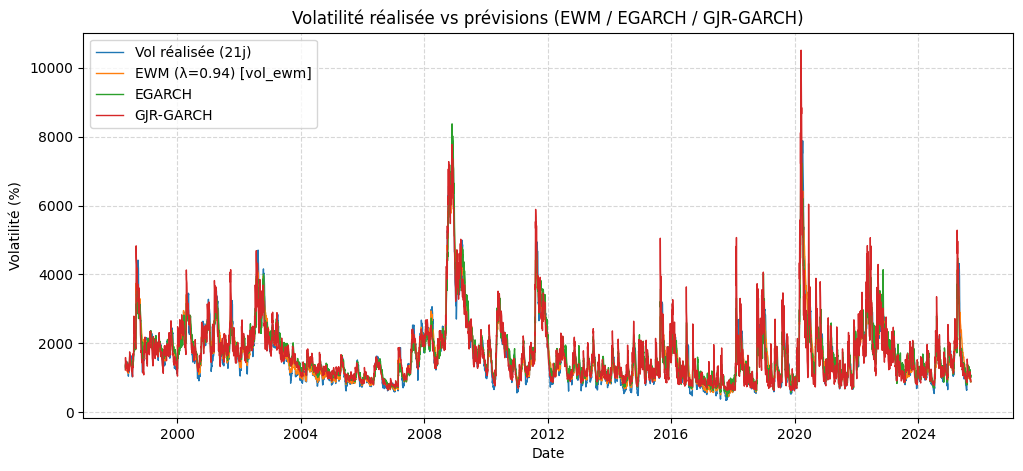

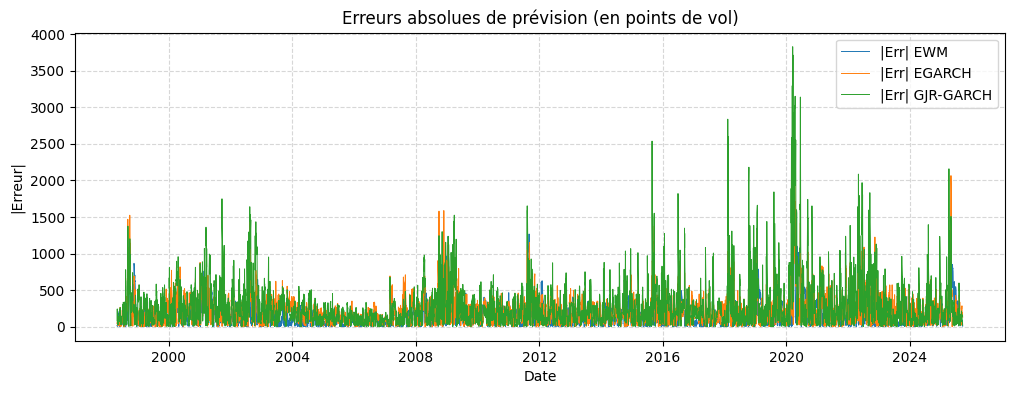

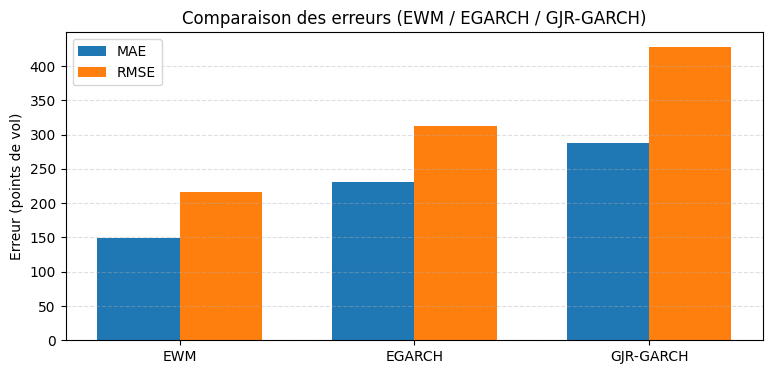

=== Résumé des erreurs (en points de vol) ===


,MAE,RMSE
Modèle,,
EWM,149.2960,215.6513
EGARCH,230.9317,312.8790
GJR-GARCH,287.9815,427.8889


In [8]:
def to_datetime_inplace(df, col="date"):
    if col not in df.columns:
        if df.index.name is not None:
            df = df.reset_index().rename(columns={df.index.name: col})
        else:
            df = df.reset_index().rename(columns={"index": col})
    if not pd.api.types.is_datetime64_any_dtype(df[col]):
        df[col] = pd.to_datetime(df[col])
    return df

def ensure_core_columns(df):
    """
    Assure la présence de:
      - vol21 (vol réalisée 21j) dans df["vol21"]  (ou la mappe depuis une colonne 'vol_real' existante),
      - une colonne EWM (retourne son nom via ewm_col).

    Si 'ret_d' n'existe pas et qu'on ne peut pas le reconstruire (pas de prix),
    on n'échoue PAS si des colonnes de vol prêtes à l'emploi existent déjà.
    """
    cols = {c.lower(): c for c in df.columns}

    if "vol21" not in df.columns:
        realized_candidates = [c for c in df.columns
                               if any(k in c.lower() for k in ["vol21", "vol_real", "realized", "realised", "rv"])]
        if realized_candidates:
            df["vol21"] = df[realized_candidates[0]]
        else:
            pass

    # --- 2) EWM ---
    ewm_candidates = [c for c in df.columns if ("ewm" in c.lower()) and any(k in c.lower() for k in ["vol","sigma"])]
    if ewm_candidates:
        ewm_col = ewm_candidates[0]
    else:
        if "ret_d" not in df.columns:
            price_col = None
            for c in ["adj_close","close","Adj Close","Close"]:
                if c in df.columns:
                    price_col = c; break
            if price_col is None:
                cand = [c for c in df.columns if ("adj_close" in c.lower()) or c.lower().endswith("_adj_close")]
                price_col = cand[0] if cand else None
            if price_col is not None:
                df["ret_d"] = df[price_col].pct_change()

        if "ret_d" in df.columns:
            if "vol21" not in df.columns:
                df["vol21"] = df["ret_d"].rolling(21).std()
            lam = 0.94
            df["vol_ewm_094"] = np.sqrt(df["ret_d"].pow(2).ewm(alpha=1-lam, adjust=False).mean())
            ewm_col = "vol_ewm_094"
        else:
            wide_ewm = [c for c in df.columns if any(k in c.lower() for k in ["ewm","ewma","riskmetrics","lambda"]) and
                        any(k in c.lower() for k in ["vol","sigma"])]
            if wide_ewm:
                ewm_col = wide_ewm[0]
            else:
                if "vol21" in df.columns:
                    raise ValueError(
                        "Aucune EWM détectée et impossible de la calculer (pas de 'ret_d' ni de colonne de prix). "
                        f"Colonnes dispo: {list(df.columns)[:25]}..."
                    )
                else:
                    raise ValueError(
                        "Impossible d'assurer les colonnes de base: ni 'ret_d' (ou prix) ni 'vol' existantes. "
                        f"Colonnes dispo: {list(df.columns)[:25]}..."
                    )

    if "vol21" not in df.columns:
        raise ValueError("Échec inattendu: 'vol21' manquant après tentative de mappage/calcul.")

    return df, ewm_col


def find_model_col(df, keywords):
    cols = [c for c in df.columns if all(k in c.lower() for k in keywords)]
    if cols:
        return cols[0]
    main = keywords[0]
    fallback = [c for c in df.columns if (main in c.lower() and any(k in c.lower() for k in ["vol","sigma","fore","pred"]))]
    return fallback[0] if fallback else None

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

# ---------- 0) Récupérer df ----------
g = globals()
if "df" in g and isinstance(g["df"], pd.DataFrame):
    df = g["df"].copy()
else:
    PROC_DIR = Path("data/processed")
    candidates = [
        PROC_DIR / "spx_index_features.parquet",
        *sorted(PROC_DIR.glob("*spx*features*.parquet")),
        *sorted(PROC_DIR.glob("spx*.parquet"))
    ]
    for p in candidates:
        if p.exists():
            df = pd.read_parquet(p).copy()
            break
    else:
        raise FileNotFoundError("Aucun fichier SPX features trouvé dans data/processed/")

df = to_datetime_inplace(df, "date")
df, ewm_col = ensure_core_columns(df)

# ---------- 1) Identifier EGARCH / GJR-GARCH ----------
series_preds = {}
if "egarch_pred" in g: series_preds["EGARCH"] = pd.Series(g["egarch_pred"]).astype(float)
if "gjr_pred"    in g: series_preds["GJR-GARCH"] = pd.Series(g["gjr_pred"]).astype(float)

if "EGARCH" not in series_preds:
    col_eg = find_model_col(df, ["egarch"])
    if col_eg is not None: series_preds["EGARCH"] = df[col_eg]
if "GJR-GARCH" not in series_preds:
    col_gjr = find_model_col(df, ["gjr"])
    if col_gjr is not None: series_preds["GJR-GARCH"] = df[col_gjr]

# ---------- 2) DataFrame de tracé (en %) ----------
plot = df[["date","vol21", ewm_col]].dropna().copy()
plot.rename(columns={"vol21":"Realized", ewm_col:"EWM"}, inplace=True)
plot["Realized"] = plot["Realized"] * 100.0
plot["EWM"]      = plot["EWM"] * 100.0

for name, s in series_preds.items():
    if isinstance(s, pd.Series) and s.shape[0] == df.shape[0]:
        plot[name] = np.asarray(s, dtype=float) * 100.0
    else:
        tmp = pd.DataFrame({"date": df["date"].values, name: np.asarray(s, dtype=float)}) if len(s)==len(df) else None
        if tmp is not None:
            plot = plot.merge(tmp[["date",name]], on="date", how="left")
            plot[name] = plot[name] * 100.0

plot = plot.dropna(subset=["Realized","EWM"])

# ---------- 3) Graphiques ----------
plt.figure(figsize=(12,5))
plt.plot(plot["date"], plot["Realized"], lw=1.0, label="Vol réalisée (21j)")
plt.plot(plot["date"], plot["EWM"],      lw=1.0, label=f"EWM (λ=0.94) [{ewm_col}]")
for name in ["EGARCH","GJR-GARCH"]:
    if name in plot.columns and plot[name].notna().any():
        plt.plot(plot["date"], plot[name], lw=1.0, label=name)
plt.title("Volatilité réalisée vs prévisions (EWM / EGARCH / GJR-GARCH)")
plt.xlabel("Date"); plt.ylabel("Volatilité (%)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(); plt.show()

err = pd.DataFrame({"date": plot["date"]})
err["|Err| EWM"] = (plot["Realized"] - plot["EWM"]).abs()
for name in ["EGARCH","GJR-GARCH"]:
    if name in plot.columns:
        err[f"|Err| {name}"] = (plot["Realized"] - plot[name]).abs()

plt.figure(figsize=(12,4))
plt.plot(err["date"], err["|Err| EWM"], lw=0.7, label="|Err| EWM")
if f"|Err| EGARCH" in err.columns:
    plt.plot(err["date"], err["|Err| EGARCH"], lw=0.7, label="|Err| EGARCH")
if f"|Err| GJR-GARCH" in err.columns:
    plt.plot(err["date"], err[f"|Err| GJR-GARCH"], lw=0.7, label="|Err| GJR-GARCH")
plt.title("Erreurs absolues de prévision (en points de vol)")
plt.xlabel("Date"); plt.ylabel("|Erreur|")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(); plt.show()

# Barplot MAE/RMSE
metrics = [("EWM",
            mae(plot["Realized"], plot["EWM"]),
            rmse(plot["Realized"], plot["EWM"]))]

if "EGARCH" in plot.columns and plot["EGARCH"].notna().any():
    metrics.append(("EGARCH",
                    mae(plot["Realized"], plot["EGARCH"]),
                    rmse(plot["Realized"], plot["EGARCH"])))
if "GJR-GARCH" in plot.columns and plot["GJR-GARCH"].notna().any():
    metrics.append(("GJR-GARCH",
                    mae(plot["Realized"], plot["GJR-GARCH"]),
                    rmse(plot["Realized"], plot["GJR-GARCH"])))

met_df = pd.DataFrame(metrics, columns=["Modèle","MAE","RMSE"])
plt.figure(figsize=(9,4))
x = np.arange(len(met_df)); w = 0.35
plt.bar(x - w/2, met_df["MAE"],  width=w, label="MAE")
plt.bar(x + w/2, met_df["RMSE"], width=w, label="RMSE")
plt.xticks(x, met_df["Modèle"])
plt.title("Comparaison des erreurs (EWM / EGARCH / GJR-GARCH)")
plt.ylabel("Erreur (points de vol)")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend(); plt.show()

print("=== Résumé des erreurs (en points de vol) ===")
display(met_df.set_index("Modèle").round(4))
